In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score, 
    roc_auc_score, confusion_matrix, roc_curve, auc, pairwise_kernels
)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle


## 1. Supervised, Semi-Supervised, and Unsupervised Learning

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set
Download the Breast Cancer Wisconsin (Diagnostic) Data Set from: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [2]:
cancer_cols = [
	"ID",
    "diagnosis", # (M = malignant / 1, B = benign / 0)
    "radius1",
    "texture1",
    "perimeter1",
    "area1",
    "smoothness1",
    "compactness1",
    "concavity1",
    "concave_points1",
    "symmetry1",
    "fractal_dimension1",
    "radius2",
    "texture2",
    "perimeter2",
    "area2",
    "smoothness2",
    "compactness2",
    "concavity2",
    "concave_points2",
    "symmetry2",
    "fractal_dimension2",
    "radius3",
    "texture3",
    "perimeter3",
    "area3",
    "smoothness3",
    "compactness3",
    "concavity3",
    "concave_points3",
    "symmetry3",
    "fractal_dimension3"
]

cancer_data = pd.read_csv("data/wdbc.data", header=None)
cancer_df = pd.DataFrame(cancer_data.values, columns=cancer_cols)

cancer_df.drop("ID", axis=1, inplace=True)
cancer_df["label"] = cancer_df["diagnosis"].apply(lambda a: 0 if a in ["M"] else 1)
cancer_df.drop("diagnosis", axis=1, inplace=True)

cancer_Xvars = [item for item in cancer_cols if item not in ["ID", "diagnosis"]]
cancer_yvar = "label"

print(cancer_df)

    radius1 texture1 perimeter1   area1 smoothness1 compactness1 concavity1  \
0     17.99    10.38      122.8  1001.0      0.1184       0.2776     0.3001   
1     20.57    17.77      132.9  1326.0     0.08474      0.07864     0.0869   
2     19.69    21.25      130.0  1203.0      0.1096       0.1599     0.1974   
3     11.42    20.38      77.58   386.1      0.1425       0.2839     0.2414   
4     20.29    14.34      135.1  1297.0      0.1003       0.1328      0.198   
..      ...      ...        ...     ...         ...          ...        ...   
564   21.56    22.39      142.0  1479.0       0.111       0.1159     0.2439   
565   20.13    28.25      131.2  1261.0      0.0978       0.1034      0.144   
566    16.6    28.08      108.3   858.1     0.08455       0.1023    0.09251   
567    20.6    29.33      140.1  1265.0      0.1178        0.277     0.3514   
568    7.76    24.54      47.92   181.0     0.05263      0.04362        0.0   

    concave_points1 symmetry1 fractal_dimension1  .

### Monte-Carlo Simulation
Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

In [ ]:
# functions for data splitting - supervised, semi-supervised, unsupervised

def split_sup_unsup(i, X0, y0, X1, y1):

    # 20% of each class as test set
    X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=i)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=i)

    X_train = pd.concat([X0_train, X1_train])
    y_train = pd.concat([y0_train, y1_train])
    X_test = pd.concat([X0_test, X1_test])
    y_test = pd.concat([y0_test, y1_test])

    # scale using only train data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # convert back to arrays for consistency
    X_train = pd.DataFrame(X_train, columns=cancer_Xvars)
    X_test = pd.DataFrame(X_test, columns=cancer_Xvars)

    # shuffle data so that it is not displayed by pos / neg class
    # shuffle only works with np arrays or dfs
    X_train, y_train = shuffle(X_train, y_train, random_state=i)
    X_test, y_test = shuffle(X_test, y_test, random_state=i)

    return X_train, y_train, X_test, y_test

def split_semisupervised(i, X0, y0, X1, y1):

    # 20% of each class as test set
    X0_trainval, X0_test, y0_trainval, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=i)
    X1_trainval, X1_test, y1_trainval, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=i)

    # 50% of each remaining class as labeled data - ignore y values of unlabled data
    X0_labeled, X0_unlabeled, y0_labeled, _ = train_test_split(X0_trainval, y0_trainval, test_size=0.5, random_state=i)
    X1_labeled, X1_unlabeled, y1_labeled, _ = train_test_split(X1_trainval, y1_trainval, test_size=0.5, random_state=i)

    # for initial training of SVM
    X_labeled = pd.concat([X0_labeled, X1_labeled])
    y_labeled = pd.concat([y0_labeled, y1_labeled])

    # for iterative labeling using SVM - retrain model with newly labeld vals
    X_unlabeled = pd.concat([X0_unlabeled, X1_unlabeled])

    # for final model evaluation
    X_test = pd.concat([X0_test, X1_test])
    y_test = pd.concat([y0_test, y1_test])

    # standardize using only the labeled training data
    scaler = StandardScaler()
    X_labeled = scaler.fit_transform(X_labeled)
    X_unlabeled = scaler.transform(X_unlabeled)
    X_test = scaler.transform(X_test)

    return X_labeled, y_labeled, X_unlabeled, X_test, y_test


In [306]:
# model assessment functions - scores (f1, accuracy, etc), confusion matrix, roc auc curves
def assess_model(model, X, y, y_pred):

    f1 = f1_score(y, y_pred, average='macro')
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')

    y_score = model.decision_function(X)
    auc = roc_auc_score(y, y_score)

    return f1, accuracy, precision, recall, auc

def assess_cluster_model(y, y_pred):

    f1 = f1_score(y, y_pred, average='macro')
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    auc = roc_auc_score(y, y_pred)

    return f1, accuracy, precision, recall, auc

def get_matrix(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))

    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

# used source 3, 4
def get_curve_matrix_semi_sup(model, X_train, y_train, X_test, y_test):
    get_matrix(model, X_train, y_train, X_test, y_test)

    # get raw decision scores - decision_function() returns confidence scores for predictions
    y_train_conf = model.decision_function(X_train)
    y_test_conf = model.decision_function(X_test)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_conf, pos_label=1)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_conf, pos_label=1)

    auc_train = roc_auc_score(y_train, y_train_conf)
    auc_test = roc_auc_score(y_test, y_test_conf)

    # plot roc auc curve
    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}')
    plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}')
    plt.plot([0, 1], [0, 1], ':', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# apply softmax activation function to return probabilities
# "numerically stable" calculation - tells the computer how to handle v. large or small nums
# in softmax, e^x can get VERY large which can cause overflow or return inf
# prevent this by subtracting the maximum value before applying the exponential
# numerically stable used when nums can get too big or small -- in cross entropy, KL-Divergence / Entropy, PCA, vanishing gradient descent in neural networks
def stable_softmax(x):
    z = x - np.max(x, axis=-1, keepdims=True) # sub max element of all elements
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis=-1, keepdims=True)
    softmax = numerator / denominator # take softmax of stable vector z
    return softmax

# K-means algorithm does not provide probabilities
# use the distances from cluster center and pass them through a softmax to calculate probabilities
# used sources 9, 10, 11
def get_curve_matrix_kmeans(model, X_train, y_train, X_test, y_test, pos_clust):
    get_matrix(model, X_train, y_train, X_test, y_test)
    
    # get distances to cluster centers
    distances = cdist(X_test, model.cluster_centers_)
    
    # raw distances (+ / -) have an inverse relationship to class probability (closer = higher score --> higher probability for higher scores)
    # use negative distances to flip this so that (closer = lower score --> higher probability for lower scores)
    softmax_scores = stable_softmax(-distances)

    # use softmax score for the positive cluster as the "probability" of class 1
    y_test_score = softmax_scores[:, pos_clust]

    # ROC & AUC with soft scores
    fpr, tpr, _ = roc_curve(y_test, y_test_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'Softmax AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], ':', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Distance-Based ROC Curve (KMeans)')
    plt.legend(loc='lower right')
    plt.show()


# Spectral clustering algorithm does not provide probabilities
# vary the threshold of majority polling to obtain an ROC 
def get_curve_matrix_spectral(y_train, y_train_pred, y_test, y_test_pred, pos_clust, dist_0, dist_1):
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))

    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    # Use distance to positive cluster
    test_scores = -dist_0 if pos_clust == 0 else -dist_1

    fpr, tpr, _ = roc_curve(y_test, test_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Spectral Clustering ROC Curve')
    plt.legend(loc='lower right')
    plt.show()



In [ ]:
# Supervised Learning: Train an L1-penalized SVM to classify the data
# Use 5 fold cross validation to choose the penalty parameter. Use normalized data. 
# Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs

def supervised_svm(X_train, y_train, X_test, y_test, type, i):
    # parameter C
    # low, more regularization, some misclassification
    # high, less regularization, penalizes misclassification heavy, fits data closely with complex boundary, less misclassification
    param_grid = {
        "C": np.logspace(-3 ,6, num=10),
    }

    grid_search = GridSearchCV(
        LinearSVC(penalty='l1', dual=False, max_iter=100000), #dual=False required when using L1, "solves primal optimization problem"
        param_grid, scoring="f1_macro", cv=5, n_jobs=2
    )

    # train SVM for each of the labels
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # get cv scores
    best_params = grid_search.best_params_
    f1_cv = grid_search.best_score_
    
    # get train / test scores
    y_train_pred, y_test_pred = best_model.predict(X_train), best_model.predict(X_test)
    f1_test, accuracy_test, precision_test, recall_test, auc_test = assess_model(best_model, X_test, y_test, y_test_pred)
    f1_train, accuracy_train, precision_train, recall_train, auc_train = assess_model(best_model, X_train, y_train, y_train_pred)

    # plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 7:
        print(f"i: {i}, Best Model Params: {best_params}")
        get_curve_matrix_semi_sup(best_model, X_train, y_train, X_test, y_test)

    # return model data
    results = [
        type, best_params, f1_cv, 
        f1_test, accuracy_test, precision_test, recall_test, auc_test,
        f1_train, accuracy_train, precision_train, recall_train, auc_train
    ]

    return results


In [ ]:
# Train SVM w/ semi-supervised learning
# Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. 
# Plot the ROC and report the confusion matrix for training and testing in one of the runs.

def semisupervised_svm(X_labeled, y_labeled, X_unlabeled, X_test, y_test, type, i):
    # parameter C - low, more regularization, some misclassification - high, less regularization, penalizes misclassification heavy, fits data closely with complex boundary, less misclassification
    param_grid = {
        "C": np.logspace(-3 ,3, num=7),
    }

    # find unlabeled datapoint farthest to the decision boundary of the SVM and label it w/ best model (ignore its true label)
    # add it to the labeled data, and retrain until all unlabeled data used
    while len(X_unlabeled) > 0:
        grid_search = GridSearchCV(
            LinearSVC(penalty='l1', dual=False, max_iter=400000), 
            param_grid, scoring="f1_macro", cv=5, 
            n_jobs=2, refit= True
        )

        # train model on available labeled data
        grid_search.fit(X_labeled, y_labeled)
        best_model = grid_search.best_estimator_

        # get decision scores for all unlabeled points - use absolute val to assess how far the points are
        # decision_function method calculates the distance of each sample in the input data from the separating hyperplane
        decision_scores = np.abs(best_model.decision_function(X_unlabeled))

        # get index of point farthest from the decision boundary
        furthest_indx = np.argmax(decision_scores)

        # label point y val + add to labeled set
        newX = X_unlabeled[furthest_indx].reshape(1, -1)
        newy = best_model.predict(newX)

        X_labeled = np.vstack([X_labeled, newX]) # multiple features appended, vstack allows you to add rows to a np array
        y_labeled = np.append(y_labeled, newy)

        # remove point from unlabeled set
        X_unlabeled = np.delete(X_unlabeled, furthest_indx, axis=0)

        # loop again and repeat until there are no more unlabeled data points in X_unlabeled
    
    # train final SVM using all newly labeled data
    grid_search.fit(X_labeled, y_labeled)
    best_model = grid_search.best_estimator_

    # get params and cv scores for the best trained model
    best_params = grid_search.best_params_
    f1_cv = grid_search.best_score_

    # get train / test scores
    y_train_pred, y_test_pred = best_model.predict(X_labeled), best_model.predict(X_test)
    f1_test, accuracy_test, precision_test, recall_test, auc_test = assess_model(best_model, X_test, y_test, y_test_pred)
    f1_train, accuracy_train, precision_train, recall_train, auc_train = assess_model(best_model, X_labeled, y_labeled, y_train_pred)

    # plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 7:
        print(f"i: {i}, Best Model Params: {best_params}")
        get_curve_matrix_semi_sup(best_model, X_labeled, y_labeled, X_test, y_test)

    # return model data
    results = [
        type, best_params, f1_cv, 
        f1_test, accuracy_test, precision_test, recall_test, auc_test,
        f1_train, accuracy_train, precision_train, recall_train, auc_train
    ]

    return results

In [ ]:
# optional simple visualization of k means and spectral clustering - used source 15
# must visualize in 2D, but we have many features so use dimensionality reduction technique PCA to reduce to 2 components for plotting

def plot_clusters(X, cluster_assignments):
    # cannot plot directly, so we must reduce to 2D using PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    # plot predictions for each cluster
    plt.figure(figsize=(5, 5))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_assignments, cmap='rainbow', s=30)
    plt.title("Data Clustering")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

In [ ]:
# Run k-means algorithm on the whole training set - assume k = 2

def unsupervised_kmeans(X_train, y_train, X_test, y_test, type, i, k):
    # run the k-means algorithm multiple times (initializing randomly)
    clusterer = KMeans(n_clusters=k, random_state=i, n_init=100)
    clusterer.fit(X_train)

    # compute the centers of the two clusters + find the closest 30 data points to each center
    # returns np array - cluster, coordinate of the cluster center in that feature
    cluster_centers = clusterer.cluster_centers_ 

    closest_points0 = []
    closest_points1 = []

    # calculate distances from all data points to the cluster center
    for clust, centroid in enumerate(cluster_centers):
        distances = cdist(X_train, centroid.reshape(1, -1))
        closest_points = np.argsort(distances.ravel())[:30] # get index of 30 points closest to the centroid
 
        # add 30 closest data points to list for its associated cluster
        if clust == 0:
            closest_points0.extend(closest_points)
        elif clust == 1:
            closest_points1.extend(closest_points)


    # read true labels of closest 30 points + take a majority poll within them
    # majority poll becomes the label predicted by k-means for the members of each cluster
    true_labels0 = y_train.iloc[closest_points0] # make dfs of true labels using closest indices
    true_labels1 = y_train.iloc[closest_points1]

    # take majority vote (M = malignant / 1, B = benign / 0)
    # use mode, which returns the value that appears the most - if tie, return the first value
    majority_label0 = true_labels0.mode().iloc[0]
    majority_label1 = true_labels1.mode().iloc[0]

    # make map of majority labels in both clusters
    cluster_label_map = {0: majority_label0, 1: majority_label1}

    # compare the labels provided by k-means with the true labels of the training data
    # report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs (1)
    train_cluster_assignments = clusterer.predict(X_train) # outputs list of cluster assigned to each datapoint (0 or 1)
    test_cluster_assignments = clusterer.predict(X_test)

    y_train_pred, y_test_pred = [], []
    for c in train_cluster_assignments:
        train_pred_label = cluster_label_map[c]  # assign predicted label based on majority label
        y_train_pred.append(train_pred_label)

    for c in test_cluster_assignments:
        test_pred_label = cluster_label_map[c]  # assign predicted label based on majority label
        y_test_pred.append(test_pred_label)

    # assess model with train and test data
    f1_train, accuracy_train, precision_train, recall_train, auc_train = assess_cluster_model(y_train, y_train_pred)
    f1_test, accuracy_test, precision_test, recall_test, auc_test = assess_cluster_model(y_test, y_test_pred)

    # find which cluster corresponds to class 1 / Malignant
    pos_clust = [cluster for cluster, label in cluster_label_map.items() if label == 1][0]
    
    # plot the ROC and report the confusion matrix for training and testing in one of the runs
    if i == 7:
        print(f"i: {i}")
        get_curve_matrix_kmeans(clusterer, X_train, y_train, X_test, y_test, pos_clust)
        plot_clusters(X_train, train_cluster_assignments)

    # return model data
    best_params = "N/A"
    f1_cv = "N/A"
    results = [
        type, best_params, f1_cv, 
        f1_test, accuracy_test, precision_test, recall_test, auc_test,
        f1_train, accuracy_train, precision_train, recall_train, auc_train
    ]

    return results


In [ ]:
# Spectral Clustering
# Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters 

def unsupervised_spectral(X_train, y_train, X_test, y_test, type, i, k):
    # fit spectral clustering with RBF kernel, gamma=1
    # find a gamma for which the two clutsres have the same balance as the one in original data set 
    pos_ratio = (y_train == 1).sum() / len(y_train) # original class proportions

    best_gamma = None
    best_diff = float('inf')
    best_assignments = None

    for gamma in [.00001, .0001, .001, .01, .1, 1, 2]:
        clusterer = SpectralClustering(
            n_clusters=k, affinity='rbf', gamma=gamma,
            assign_labels='kmeans', random_state=i,
            eigen_solver='arpack', # more robust and widely compatible eigenvalue solver, used bc I was getting "graph not fully convering"
            eigen_tol=1e-5 # sets convergence tolerance for the eigenvalue solver, larger value = easier convergence / faster but less precise, smaller value = stricter accuracy, may fail
        )

        assignments = clusterer.fit_predict(X_train)
        cluster_0_ratio = (assignments == 0).sum() / len(assignments)
        diff = abs(cluster_0_ratio - pos_ratio)
        
        # find best gamma based on cluster balance and compare to original dataset
        # cannot use gridsearch bc we don't have measures like accuracy w/ unlabeled data - find class ration closest to original data
        if diff < best_diff:
            best_diff = diff
            best_gamma = gamma
            best_assignments = assignments

    # fit model with best gamma
    clusterer = SpectralClustering(
        n_clusters=k, affinity='rbf', gamma=best_gamma,
        assign_labels='kmeans', random_state=i, 
        eigen_tol=1e-5, eigen_solver='arpack'
    )
    train_cluster_assignments = clusterer.fit_predict(X_train) # use fit−predict method

    # spectral clustering will not give you cluster centers
    # label using all data points from each cluster - get indices
    cluster_0_indices = np.where(train_cluster_assignments == 0)[0]
    cluster_1_indices = np.where(train_cluster_assignments == 1)[0]

    # fit_predict for test_cluster_assignments not ideal, bc the model is then fit with TEST data which is no good, but spectral does not have .predict method
    # do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters .

    # assign labels using majority vote while still using structure learned during training
    knn = KNeighborsClassifier(n_neighbors=30)
    knn.fit(X_train, train_cluster_assignments)
    test_cluster_assignments = knn.predict(X_test)

    majority_label0 = y_train.iloc[cluster_0_indices].mode().iloc[0]
    majority_label1 = y_train.iloc[cluster_1_indices].mode().iloc[0]

    cluster_label_map = {0: majority_label0, 1: majority_label1}

    y_train_pred, y_test_pred = [], []
    for c in train_cluster_assignments:
        train_pred_label = cluster_label_map[c]  # assign predicted label based on majority label
        y_train_pred.append(train_pred_label)

    for c in test_cluster_assignments:
        test_pred_label = cluster_label_map[c]  # assign predicted label based on majority label
        y_test_pred.append(test_pred_label)

    # assess model on train and test data
    f1_train, accuracy_train, precision_train, recall_train, auc_train = assess_cluster_model(y_train, y_train_pred)
    f1_test, accuracy_test, precision_test, recall_test, auc_test = assess_cluster_model(y_test, y_test_pred)

    # get representative points for getting the roc auc curve
    rep_0 = X_train.iloc[cluster_0_indices].mean(axis=0).values
    rep_1 = X_train.iloc[cluster_1_indices].mean(axis=0).values
    
    dist_0 = cdist(X_test, rep_0.reshape(1, -1)).ravel()
    dist_1 = cdist(X_test, rep_1.reshape(1, -1)).ravel()

    pos_clust = [cluster for cluster, label in cluster_label_map.items() if label == 1][0]

    if i == 7:
        print(f"i: {i}")
        get_curve_matrix_spectral(y_train, y_train_pred, y_test, y_test_pred, pos_clust, dist_0, dist_1)
        plot_clusters(X_train, train_cluster_assignments)

    results = [
        type, f"gamma={best_gamma:.3f}", "N/A",
        f1_test, accuracy_test, precision_test, recall_test, auc_test,
        f1_train, accuracy_train, precision_train, recall_train, auc_train
    ]
    return results

In [ ]:
# Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times
# Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.
def monte_carlo(n_simulations, df, type, k=2):
    results = []
    np.random.seed(13)

    # split df by class label and X/y var
    df0 = df[df['label'] == 0] # 0 / Benign
    df1 = df[df['label'] == 1] # 1 / Malignant

    X0, y0 = df0[cancer_Xvars], df0[cancer_yvar]
    X1, y1 = df1[cancer_Xvars], df1[cancer_yvar]

    results_cols = [
        "model", "best_params", "f1_cv", 
        "f1_test", "accuracy_test", "precision_test", "recall_test", "auc_test",
        "f1_train", "accuracy_train", "precision_train", "recall_train", "auc_train"
    ]

    for i in range(n_simulations):
        # split data, choose model - run + evaluate
        if type=="supervised svm":
            X_train, y_train, X_test, y_test = split_sup_unsup(i, X0, y0, X1, y1)
            result = supervised_svm(X_train, y_train, X_test, y_test, type, i)
        if type=="semi-supervised svm":
            X_labeled, y_labeled, X_unlabeled, X_test, y_test = split_semisupervised(i, X0, y0, X1, y1)
            result = semisupervised_svm(X_labeled, y_labeled, X_unlabeled, X_test, y_test, type, i)
        if type=="unsupervised kmeans":
            X_train, y_train, X_test, y_test = split_sup_unsup(i, X0, y0, X1, y1)
            result = unsupervised_kmeans(X_train, y_train, X_test, y_test, type, i, k)
        if type=="unsupervised spectral":
            X_train, y_train, X_test, y_test = split_sup_unsup(i, X0, y0, X1, y1)
            result = unsupervised_spectral(X_train, y_train, X_test, y_test, type, i, k)

        results.append(result)

    monte_carlo_results = pd.DataFrame(results, columns=results_cols)
    avg_cols, avg_data = ["model"], [type]

    # report avg accuracy, precision, recall, F1-score, and AUC, for both training and test sets over M runs
    for col in results_cols:
        if col in ["model", "best_params", "f1_cv"]:
            pass
        else:
            avg = monte_carlo_results[col].mean()
            col_avg_name = col + "_avg"
            avg_cols.append(col_avg_name)
            avg_data.append(avg)

    monte_carlo_avg = pd.DataFrame([avg_data], columns=avg_cols)

    return monte_carlo_avg

#### Supervised Learning
Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

i: 7, Best Model Params: {'C': 0.1}
Train Confusion Matrix:
[[163   6]
 [  4 281]]

Test Confusion Matrix:
[[43  0]
 [ 1 71]]


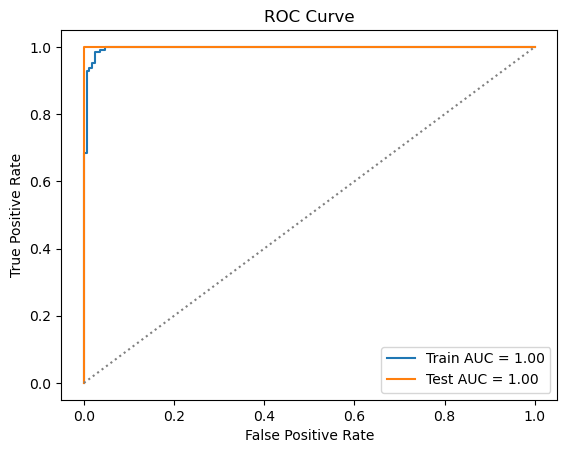

            model  f1_test_avg  accuracy_test_avg  precision_test_avg  \
0  supervised svm     0.972817           0.974783            0.976209   

   recall_test_avg  auc_test_avg  f1_train_avg  accuracy_train_avg  \
0         0.970338      0.993669      0.984616            0.985683   

   precision_train_avg  recall_train_avg  auc_train_avg  
0             0.986767          0.982616       0.997315  


In [216]:
supervised_mc = monte_carlo(30, cancer_df, "supervised svm")
print(supervised_mc)

#### Semi-Supervised Learning/ Self-training
Select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly. <br>

Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation. <br>

Find the unlabeled datapoint that is the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

i: 7, Best Model Params: {'C': 0.1}
Train Confusion Matrix:
[[170   5]
 [  1 278]]

Test Confusion Matrix:
[[43  0]
 [ 3 69]]


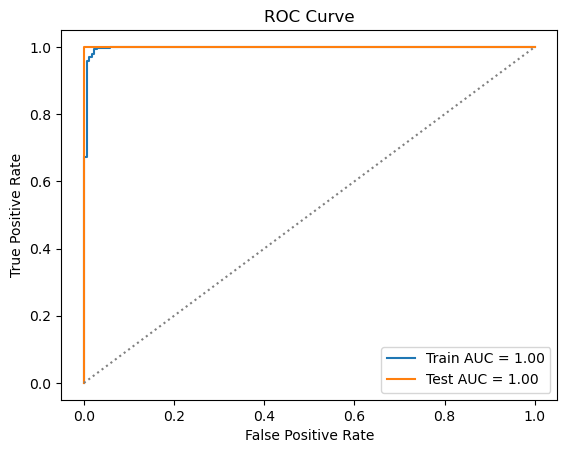

                 model  f1_test_avg  accuracy_test_avg  precision_test_avg  \
0  semi-supervised svm     0.956159            0.95913             0.95875   

   recall_test_avg  auc_test_avg  f1_train_avg  accuracy_train_avg  \
0         0.955028      0.986143      0.993277            0.993759   

   precision_train_avg  recall_train_avg  auc_train_avg  
0             0.994308          0.992321       0.999091  


In [312]:
semisupervised_mc = monte_carlo(30, cancer_df, "semi-supervised svm")
print(semisupervised_mc)

#### Unsupervised Learning
Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2. <br>

**(A)** Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum? <br>

**(B)** Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs. <br>

**(C)** Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data (2). <br>

(2) - K-means algorithm does not provide probabilities, so one can use the distances from cluster center and pass them through a softmax to calculate probabilities. Alternatively, one can calculate the ROC curve by varying the threshold for majority polling. Usually, a majority is achieved when t = 50% of the data are in a class. one can vary t and obtain an ROC curve.

One issue with the KMeans algorithm is that the random initialization of cluster centers often results in poor clustering results due to its greedy nature. While it is not possible to 100% ensure that the k means algorithm doesnt get trapped in a local minimum, there are a few ways to greatly decrease your chances of being trapped at a local min. A common option in SK Learn is to set the n_init parameter and then choosing the run that gives the lowest error. You can also use the KMeans++ algorithm, which improves the way cluster centers are selected to make the resulting clusters more accurate. This algorithm is interesting because it chooses the first cluster center randomly from the data points, but then chooses the remaining cluster centers in a "smarter" way. For the remaining data points, it calculates the distance to its nearest already selected cluster center. Then, it squares that distance and selects the next center randomly, but the points that are further away from the existing centers are more likely to get chosen, hence decreasing the probability that the algorithm will get stuck at a local minimum. <br>

i: 7
Train Confusion Matrix:
[[140  29]
 [ 10 275]]

Test Confusion Matrix:
[[36  7]
 [ 3 69]]


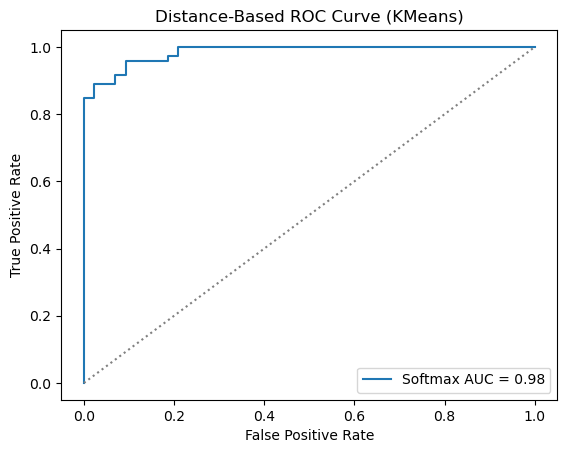

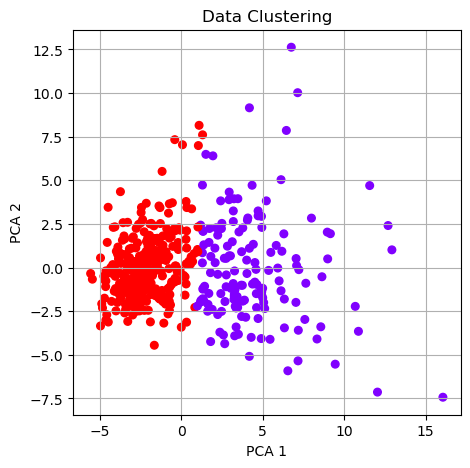

                 model  f1_test_avg  accuracy_test_avg  precision_test_avg  \
0  unsupervised kmeans     0.903697           0.911884            0.915225   

   recall_test_avg  auc_test_avg  f1_train_avg  accuracy_train_avg  \
0         0.896065      0.896065      0.900209            0.908811   

   precision_train_avg  recall_train_avg  auc_train_avg  
0             0.911914          0.892086       0.892086  


In [335]:
unsup_kmeans_mc = monte_carlo(30, cancer_df, "unsupervised kmeans")
print(unsup_kmeans_mc)

#### (iv) Spectral Clustering
Repeat 1(b)iii using spectral clustering, which is clustering based on kernels (3). Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method. <br>

(3) - Because Spectral Clustering will not give you cluster centers, instead of considering 30 closest data points to the center, consider labeling based on either 30 randomly selected data points or the entire points in each cluster. Also, for ROC curves, you can vary the threshold of majority polling to obtain an ROC.

**Written Response 1.iv** Spectral clustering uses connectivity between data points to form clusters. It uses eigenvectors, which are vectors that after transformation, have not changed at all except by a scalar value known as the eigenvalue, to forecast data into a lower dimensional space. In spectral clustering, data points are represented by nodes and the similarity between data points are represented by an edge. The goal is to find k clusters with data points that have the highest similarity.

(Used sources 9,10)

i: 7
Train Confusion Matrix:
[[138  31]
 [ 11 274]]

Test Confusion Matrix:
[[35  8]
 [ 0 72]]


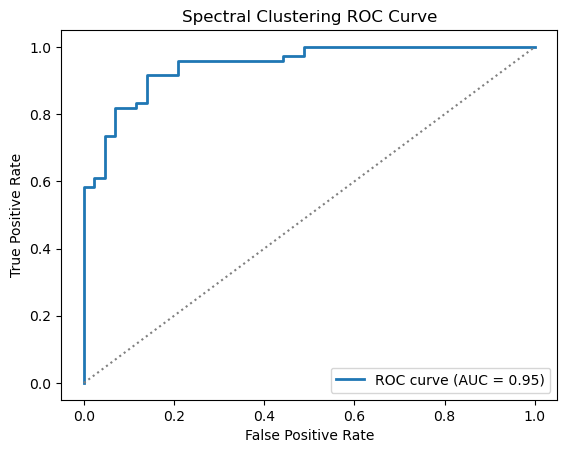

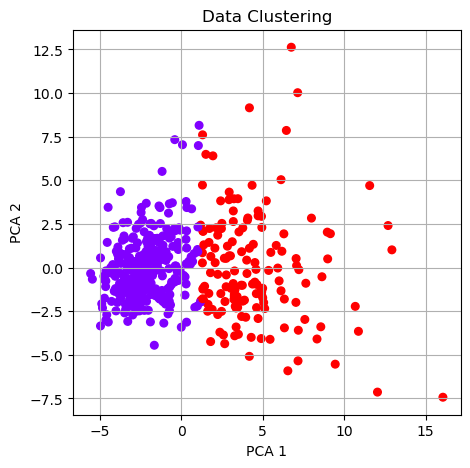

                   model  f1_test_avg  accuracy_test_avg  precision_test_avg  \
0  unsupervised spectral     0.901168           0.911884             0.92918   

   recall_test_avg  auc_test_avg  f1_train_avg  accuracy_train_avg  \
0         0.886854      0.886854      0.896276            0.905727   

   precision_train_avg  recall_train_avg  auc_train_avg  
0             0.910951          0.887101       0.887101  


In [336]:
unsup_spectral_mc = monte_carlo(30, cancer_df, "unsupervised spectral")
print(unsup_spectral_mc)

#### (v) Compare
One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled. One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

**Written Response 1v** The average values obtained by the monte carlo simulations for each model can be found in the dataframe 'model_assessment_df' below. We can confirm that the supervised SVM model performed better than both the semi-supervised SVM model and the unsupervised clustering models, as expected. <br>

The supervised model outperformed the remaining models as seen by the model test scores, such as f1 and accuracy. <br>
model, f1_test_avg, accuracy_test_avg <br>
supervised svm, 0.972817, 0.974783 <br>
semi-supervised svm, 0.955224, 0.958261  <br>
unsupervised kmeans, 0.903697, 0.911884<br>
unsupervised spectral, 0.900297, 0.908986<br>

However, in the semi-supervised model, the training averages were about 1% higher than the supervised model, which indicates that this model may have been overfit and did not generalize well with new, unseen data. It is also important to consider the computational cost of these algorithms. The supervised SVM required limited computational cost and ran very quickly. However, I had to increase the n_iter of the semi-supervised model to 400,000 so it can run without convergence warnings, which made it run about 30x longer than the supervised model. The unsupervised clustering models did run pretty quickly, but it did not perform as well. <br>

To further assess the clustering models, I also decided to visualize the cluster data by using the dimensionality reduction technique of PCA. As we can see, the spectral and k means clustering output clusters look pretty similar. However, these two techniques did vary the classification of some data points, specifically those that fell between 1 to 3 in PCA1 that fall between the seperation of Clusters A and B. <br>



In [310]:
models = [supervised_mc, semisupervised_mc, unsup_kmeans_mc, unsup_spectral_mc]
model_assessment_df = pd.concat(models).reset_index(drop=True)
print(model_assessment_df)

                   model  f1_test_avg  accuracy_test_avg  precision_test_avg  \
0         supervised svm     0.972817           0.974783            0.976209   
1        semi-supervised     0.955224           0.958261            0.957992   
2    unsupervised kmeans     0.903697           0.911884            0.915225   
3  unsupervised spectral     0.901168           0.911884            0.929180   

   recall_test_avg  auc_test_avg  f1_train_avg  accuracy_train_avg  \
0         0.970338      0.993669      0.984616            0.985683   
1         0.953865      0.953865      0.993440            0.993906   
2         0.896065      0.896065      0.900209            0.908811   
3         0.886854      0.886854      0.896276            0.905727   

   precision_train_avg  recall_train_avg  auc_train_avg  
0             0.986767          0.982616       0.997315  
1             0.994424          0.992526       0.992526  
2             0.911914          0.892086       0.892086  
3             0.

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set
Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

In [ ]:
bank_cols = [
	"variance",
    "skewness",
    "curtosis",
    "entropy",
    "class" # (0 / 1)
]

bank_data = pd.read_csv("../data/data_banknote_authentication.txt", header=None)
bank_df = pd.DataFrame(bank_data.values, columns=bank_cols)

# check for class imbalance
print(bank_df["class"].value_counts())

# define x and y variables
bank_Xvars = [item for item in bank_cols if item not in ["class"]]
bank_yvar = "class"

# split data 472 random points (test), remaining 900 points (train)
# reset indices after split
bank_df_train, bank_df_test = train_test_split(bank_df, test_size=472, stratify=bank_df["class"], random_state=13)

bank_df_train = bank_df_train.reset_index(drop=True)
bank_df_test = bank_df_test.reset_index(drop=True)

# check for class imbalance in split data
print(bank_df_test["class"].value_counts())
print(bank_df_train["class"].value_counts())

# split dfs by var
Xbank_test, ybank_test = bank_df_test[bank_Xvars], bank_df_test[bank_yvar]
Xbank_train, ybank_train = bank_df_train[bank_Xvars], bank_df_train[bank_yvar]

print(bank_df_test)

class
0.0    762
1.0    610
Name: count, dtype: int64
class
0.0    262
1.0    210
Name: count, dtype: int64
class
0.0    500
1.0    400
Name: count, dtype: int64
     variance  skewness  curtosis  entropy  class
0    3.269700   -4.3414   3.68840 -0.29829    0.0
1   -6.059800    9.2952  -0.43642 -6.36940    1.0
2   -6.508400    8.7696   0.23191 -3.93700    1.0
3    4.063200    3.5840   0.72545  0.39481    0.0
4   -0.960700    2.6963  -3.12260 -1.31210    1.0
..        ...       ...       ...      ...    ...
467 -0.014902   -1.0243  -0.94024  0.64955    1.0
468 -6.959900    8.9931   0.21820 -4.57200    1.0
469  0.661910    9.6594  -0.28819 -1.66380    0.0
470 -1.804600   -6.8141   6.70190  1.16810    1.0
471  4.012700   10.1477  -3.93660 -4.07280    0.0

[472 rows x 5 columns]


### (b) Repeat each of the following two procedures 50 times
You will have 50 errors for 90 SVMs per each procedure.

#### Passive
Train a SVM with a pool of 10 randomly selected datapoints from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning. <br>

In [338]:
# repeat 50 times
    # 1.	Randomly shuffle your training data (900 points).
	# 2.	Start with a pool of 10 randomly selected points, train an SVM with linear kernel and L1 penalty (use GridSearchCV with 5-fold CV to choose the best C).
	# 3.	Add 10 more random points without replacement, retrain, and repeat until 900 points are used.
	# 4.	At each step, compute the test error (on the fixed test set).
	# 5.	After 50 runs, you will have 50×90 = 4,500 test errors, one for each SVM trained on 10, 20, …, 900 points.

# used sources 1, 2
def passive_learning_mc(X_train, y_train, X_test, y_test):
    n_steps = X_train.shape[0] // 10 # get the number of splits that will be used
    all_errors = np.zeros((50, n_steps))

    param_grid = {"C": np.logspace(-3, 6, 10)}

    for run in range(50):
        # randomly shuffle your training data (900 points)
        X_shuffled, y_shuffled = shuffle(X_train, y_train, random_state=run)

        for step in range(1, n_steps + 1):
            # start with a pool of 10 randomly selected points
            X_data = X_shuffled[:step * 10]
            y_data = y_shuffled[:step * 10]

            # train an SVM with linear kernel and L1 penalty (use GridSearchCV with 5-fold CV to choose the best C)
            cv = StratifiedKFold(n_splits=5)
            grid_search = GridSearchCV(
                LinearSVC(penalty='l1', dual=False, max_iter=1000000),
                param_grid,
                scoring='accuracy',
                cv=cv,
                n_jobs=-1
            )
            grid_search.fit(X_data, y_data)
            best_model = grid_search.best_estimator_

            # at each step, compute the test error (on the fixed test set)
            y_pred = best_model.predict(X_test)
            error = 1 - accuracy_score(y_test, y_pred)
            all_errors[run, step - 1] = error

    return all_errors

errors_passive = passive_learning_mc(Xbank_train, ybank_train, Xbank_test, ybank_test)
print("Test Errors By Run for Passive Learning:")
print(errors_passive)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Test Errors By Run for Passive Learning:
[[0.13771186 0.12288136 0.04661017 ... 0.00635593 0.00635593 0.00635593]
 [0.07415254 0.00635593 0.00847458 ... 0.00635593 0.00635593 0.00635593]
 [0.35381356 0.06779661 0.06779661 ... 0.00635593 0.00635593 0.00635593]
 ...
 [0.15889831 0.05932203 0.02966102 ... 0.00635593 0.00635593 0.00635593]
 [0.06991525 0.12923729 0.03813559 ... 0.00635593 0.00635593 0.00635593]
 [0.12711864 0.00847458 0.01059322 ... 0.00635593 0.00423729 0.00635593]]


#### Active Learning
Train a SVM with a pool of 10 randomlys elected datapoints from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning. <br>

In [ ]:

def active_learning_mc(X_train, y_train, X_test, y_test):
    n_total = X_train.shape[0]
    n_steps = n_total // 10
    all_errors = np.zeros((50, n_steps))

    param_grid = {"C": np.logspace(-3, 6, 10)}

    for run in range(50): # 50 monte carlo runs
        # inital random selection of data
        # randomly shuffle your training data (900 points) - class 0 has 500, class 1 has 400
        X_shuffled, y_shuffled = shuffle(X_train, y_train, random_state=run)

        # if all selected data points are from one class, select another set of 10 data points randomly
        while True:
            start_data = np.random.choice(n_total, 10, replace=False)
            if len(np.unique(y_shuffled[start_data])) == 2:
                break
        
        # make sets to keep track of the indices that I have / have not trained with
        labeled_data = set(start_data)
        unlabeled_data = set(range(n_total)) - labeled_data

        for step in range(n_steps):
            # make training df with labeled data indices
            X_train_new = X_shuffled.iloc[list(labeled_data)]
            y_train_new = y_shuffled.iloc[list(labeled_data)]

            # train model and select best C
            cv = StratifiedKFold(n_splits=5)
            grid_search = GridSearchCV(
                LinearSVC(penalty='l1', dual=False, max_iter=100000000), # large max_iter to prevent nonconvergence warnings
                param_grid,
                scoring='accuracy',
                cv=cv,
                n_jobs=-1
            )
            grid_search.fit(X_train_new, y_train_new)
            best_model = grid_search.best_estimator_

            # evaluate test error
            y_pred = best_model.predict(X_test)
            error = 1 - accuracy_score(y_test, y_pred)
            all_errors[run, step] = error

            # if all points are used, do not search for next 10 nearest points - stop loop
            if len(unlabeled_data) < 10:
                break

            # select next 10 points closest to hyperplane
            # you may use the result from linear algebra about the distance of a point from a hyperplane
            X_unlabeled = X_shuffled.iloc[list(unlabeled_data)] # make df with data not used to train model
            distances = np.abs(best_model.decision_function(X_unlabeled))
            selected_datapoints = np.argsort(distances)[:10]
            new_data = np.array(list(unlabeled_data))[selected_datapoints] # list of indices of new data points

            # update used and unused indices from set
            labeled_data.update(new_data)
            unlabeled_data.difference_update(new_data)

    return all_errors

errors_active = active_learning_mc(Xbank_train, ybank_train, Xbank_test, ybank_test)
print("Test Errors By Run Using Active Learning:")
print(errors_active)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/lib/python

Test Errors By Run Using Active Learning:
[[0.25211864 0.06567797 0.02330508 ... 0.00635593 0.00635593 0.00635593]
 [0.04025424 0.01483051 0.08050847 ... 0.00635593 0.00635593 0.00635593]
 [0.20550847 0.10805085 0.02754237 ... 0.00635593 0.00635593 0.00635593]
 ...
 [0.09745763 0.01483051 0.0529661  ... 0.00635593 0.00635593 0.00635593]
 [0.01694915 0.04872881 0.02118644 ... 0.00635593 0.00635593 0.00635593]
 [0.13771186 0.09745763 0.02966102 ... 0.00635593 0.00635593 0.00635593]]


### Average the 50 test errors

**Written Response 2c** From the "Learning Curve by Monte-Carlo Simulation" graph below, we can see that despite active learning starting with a higher avg test error with n_sample = 10, it then had a smaller error rate than passive learning in the early sample sizes, as we can see a clear distinction between the orange (active learning) line and the blue (passive learning) line between n_sample of about 50 to 550. This proves that selecting the most ifornamtive points, which in this case are based off of distance, can result in a better performing models. <br>

However, interestingly, we then see that passive and active learning have very similar error rates between the sample sizes of 600 to 900. This was expected because with enough data, random sampling will eventually result in very similar class boundaries with both classes being well represented in our training dataset. <br>

One observation that I made is that the models had more trouble when training on smaller datasets. The non-convergance errors were easily addressed by increasing max_iter. However, another common error I saw when training my models was something like "UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5." This happened early on when we had a small sample size because even though we relatively balanced binary classes, when we are training with a sample size as small as 10 with a cv split of 5, we cannot guarantee that both classes will be represented in our training data. When using active learning, we accounted for this problem, which is why we can see lower test error rates, as we ensured that both classes were portrayed in our 10 randomly selected data points. <br>

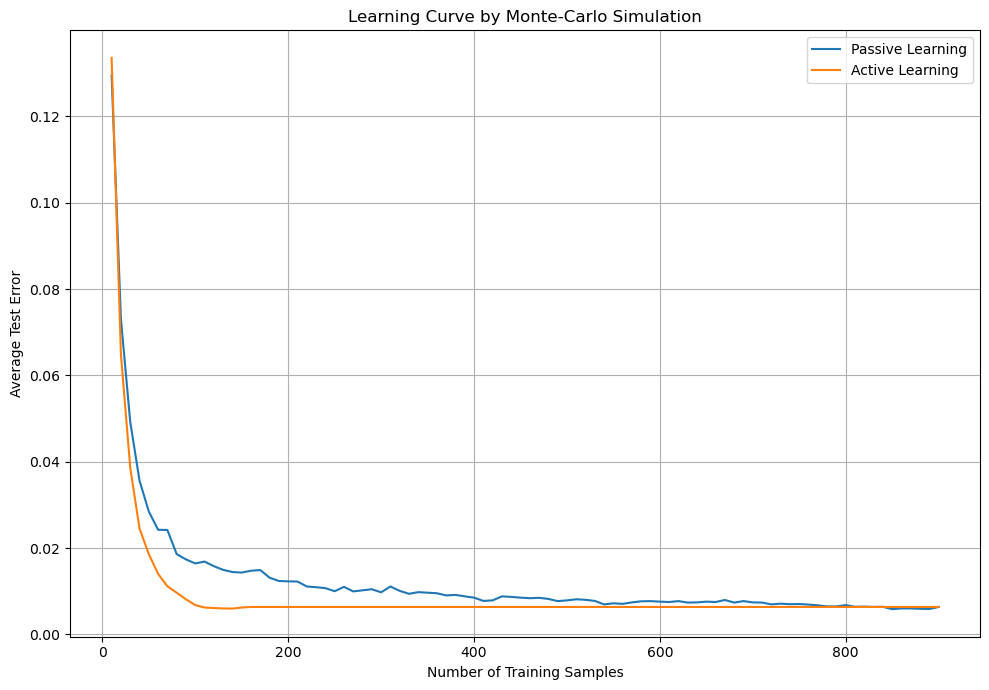

In [339]:
# get avg errors per split
passive_avg = errors_passive.mean(axis=0)
active_avg = errors_active.mean(axis=0)

# get training sample size per split (get 10 random and inc. by 10 for 900 data points)
training_samples = np.arange(10, 910, 10) 

# plot learning curves
plt.figure(figsize=(10, 7))
plt.plot(training_samples, passive_avg, label='Passive Learning')
plt.plot(training_samples, active_avg, label='Active Learning')

plt.title('Learning Curve by Monte-Carlo Simulation')
plt.xlabel('Number of Training Samples')
plt.ylabel('Average Test Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()